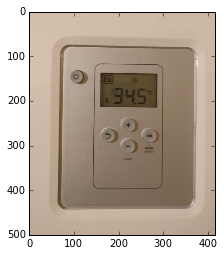

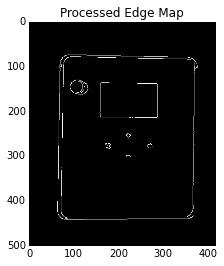

(<matplotlib.image.AxesImage at 0x1bea80f0>,
 None)

In [91]:
#Import packages, imutils is an open source package containing series of convenient OpenCV functions
#Read the image and process it 

from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
from matplotlib import pyplot as plt
import numpy as np
# define the dictionary of digit segments so we can identify
# each digit on the thermostat, for more information look at digit_reco_template.png
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image=cv2.imread('thermostat.jpg')
image=imutils.resize(image,height=500)
#OpenCV is BGR, matplotli is RGB, so using an imutils function to account for this
plt.imshow(imutils.opencv2matplotlib(image)),plt.show()
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
blurred=cv2.GaussianBlur(gray,(5,5),0)
edged=cv2.Canny(blurred,50,200,255)
plt.imshow(edged,'gray'),plt.title('Processed Edge Map'),plt.show()

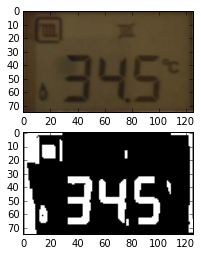

(<matplotlib.axes._subplots.AxesSubplot at 0x1b2bf670>,
 None)

In [92]:
#Extract the display, perspective transform it and then threshold and opening.

#Now find all the contours in the edge map and compare them to a rectangle
cnts=cv2.findContours(edged.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#Get all the indices of the contours found
cnts=cnts[1] 
#Sort them by area, in descending order
cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
#Create a variable to hold the indices of the rectangle
displayCnt=None
#Iterate through the contours while approximating it as a polygon
for c in cnts:
    peri=cv2.arcLength(c,True)
    approx=cv2.approxPolyDP(c,0.02*peri,True)
    #if the length of the polygon is 4 points we have the rectangle
    if len(approx)==4:
        displayCnt=approx
        break
#print displayCnt.shape
# extract the thermostat display, apply a perspective transform
# to it
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))
thresh=cv2.threshold(warped,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#print thresh
#Get an elliptical kernel, why?
kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,5))
#print kernel
#Perform erosion followed by dilation, morphological opening
thresh=cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
plt.subplot(2,1,1),plt.imshow(imutils.opencv2matplotlib(output)),plt.subplot(2,1,2),plt.imshow(thresh,'gray'),plt.show()






56 35 20 32


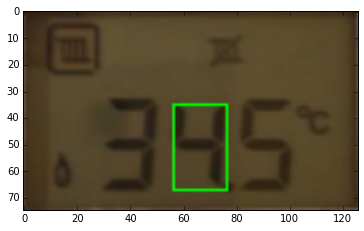

82 33 19 35


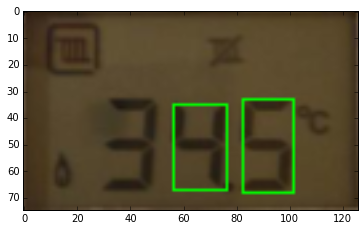

33 33 18 35


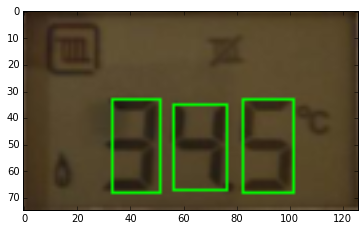

In [93]:
# find contours in the thresholded image, then initialize the
# digit contours lists
#Find Contours is an important function for finding shapes and objects during in an image
#General Strategy is to get all the contours then filter based on some criteria, in this
#case it is this width and height of the rectangle enclosing the contour!
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
digitCnts = []
 
# loop over the digit area candidates
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
#     cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),1)
#     plt.imshow(imutils.opencv2matplotlib(output)),plt.show()
 
    # if the contour is sufficiently large, it must be a digit
    if w >= 15 and (h >= 30 and h <= 40):
        digitCnts.append(c)
for i in digitCnts:
    (x,y,w,h)=cv2.boundingRect(i)
    print x,y,w,h
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),1)
    plt.imshow(imutils.opencv2matplotlib(output)),plt.show()
    



34.5 °C


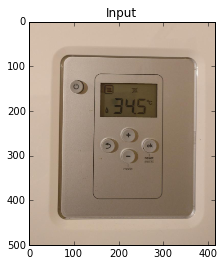

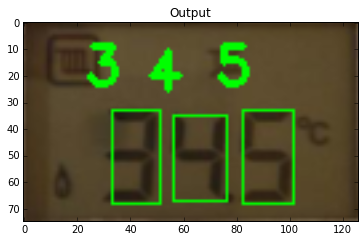

(<matplotlib.image.AxesImage at 0x1b2953b0>,
 None)

In [97]:
#Sort the digits from left to right
digitCnts=contours.sort_contours(digitCnts,method="left-to-right")[0]
digits=[]
#loop over each of the digits
for i in digitCnts:
    (x,y,w,h)=cv2.boundingRect(i)
    roi=thresh[y:y+h,x:x+w]

    #calculate the width and height of each of the seven segments for all the digits
    #Each of the segments is like a rectangle, depending on the segments that are active
    #we can identify which digit it is
    (roiH,roiW)=roi.shape
    (dW,dH)=( int(roiW*0.25),int(roiH*0.15)) #dW is the horizontal thickness of an upright segment
    #dH is the vertical thickness of a lying down segment
    dHC=int(roiH*0.05)
    
    #define the 7 segments
    segments = [
        ((0, 0), (w, dH)),	# top
        ((0, 0), (dW, h // 2)),	# top-left
        ((w - dW, 0), (w, h // 2)),	# top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)),	# bottom-left
        ((w - dW, h // 2), (w, h)),	# bottom-right
        ((0, h - dH), (w, h))	# bottom
    ]
    on = [0] * len(segments)
    #print segments

    #loop over all the segments
    for (i,((xA,yA),(xB,yB))) in enumerate(segments):
        #Extract the segment ROI from the thresholded roi
        #Count all the non zero pixels and that is the area of the thresholded segment
        #Then find the area of the segment identified by us
        segROI=roi[yA:yB,xA:xB]
        total=cv2.countNonZero(segROI)
        area=(xB-xA)*(yB-yA)
        #For each segment see how many non-zero pixels fall in the segment area
        #if the ratio is >0.5 then we can say that segment is active for the digit
        if total/float(area)>0.5:
            on[i]=1
    
    #Look up the name of the digit and draw it on the image
    #print tuple(on)
    digit=DIGITS_LOOKUP[tuple(on)]
    digits.append(digit)
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),1)
    cv2.putText(output,str(digit),(x-10,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.65,(0,255,0),2)
    
# display the digits
print(u"{}{}.{} \u00b0C".format(*digits))
plt.imshow(imutils.opencv2matplotlib(image)),plt.title("Input"),plt.show()
plt.imshow(imutils.opencv2matplotlib(output)),plt.title("Output"),plt.show()


    
    
    